# Python + DuckDB
* PyData Global 2024 demo
* DuckDb blog (aweseome resources): https://duckdb.org/news/

In [ ]:
import numpy as np
import pandas as pd
import duckdb 
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import psutil
import textwrap
from datetime import datetime
import sys

import boto3
import json
from functools import partial
import re
import s3fs
from time import sleep

import coiled

In [2]:
print("version")
print("duckdb: ",duckdb.__version__)
print("pandas: ",pd.__version__)
print("python: ",sys.version)

version
duckdb:  1.1.3
pandas:  2.2.3
python:  3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:57:01) [Clang 17.0.6 ]


In [ ]:
def memory_used():
    """ Get current memory used """
    _mbs = psutil.Process().memory_full_info().uss/(1024**2)
    print(f'Memory used: {_mbs:,.0f} MBs') 

    
def get_months(start: str,end :str) -> list:
    """ Function to get the months between the start and end date """
    return pd.date_range(start,end,freq='MS').strftime('%Y-%m')

In [4]:
memory_used()

Memory used: 117 MBs


## connection object
* There are various ways to create the connection object
    * in-memory only (RAM only). Does not support out of core operations 
    * in-memory with temporary storage:  allows out of core operation. When the connection is closed the temp storage is not persisted
    * persisted database:  in-memory + out of core operation + persistent db that can be re-used. 
    

In [5]:
_persistent_db = "~/Desktop/PyDataGlobal2024/storage.ddb"
con = duckdb.connect(_persistent_db) 

# other options to create connection: 
# duckdb.connection(":memory:")

In [6]:
def show_db_size():
    """ 
    """
    display(con.sql("call pragma_database_size()").df())


## Load the Data
* We will use the popular NYC Taxi Data

In [7]:
def get_nytaxi_data_path(month:str|list) -> str:
    """ 
    Funciton to get the month path for NYC tax
    https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
    params
        month(str): yyyy-mm format
    """
    # You can get the base path by copying the link address from the website    
    _base_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata"

    return f"{_base_path}_{month}.parquet"

# get 2024 months. Get Jan - Sep 2024 files
months = pd.date_range("2024-01",periods=9,freq="MS").strftime("%Y-%m")
nytaxi_files = [get_nytaxi_data_path(month) for month in months]
nytaxi_files


['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-08.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-09.parquet']

In [8]:
# define a fucntion that you can reuse
def ddb_read_parquet(files:str|list[str],
                     columns:list[str]=[]) -> str:
    """ 
    Function to read parquet file into duckdb
    params:
        * files(str | list): file path of list of file_path
        * cus
    """
    _cols = ',\n'.join(columns) or "*"
    _files = files if isinstance(files,list) else [files]
    # placeholder to add more params
    _read_params = "filename=true"
    
    _qry = f""" 
    select 
        {_cols}
    from read_parquet({_files},{_read_params})
    """
    
    return _qry

In [9]:
_read_qry = ddb_read_parquet(nytaxi_files[:3])
print(_read_qry)

 
    select 
        *
    from read_parquet(['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet', 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet', 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet'],filename=true)
    


### Profiling Statements
* Describe: gets the schema of the output query
* Explain: Query plan without executing it
* Explain Analyze: Query plan with execution time.

* reference: https://duckdb.org/docs/sql/statements/profiling.html

In [10]:
# checkthe schema of the output query
print("Check the schema using the DESCRIBE statement")
_desc_qry = f"DESCRIBE {_read_qry}"
con.sql(_desc_qry)

# other query profiling statement


Check the schema using the DESCRIBE statement


┌───────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│      column_name      │ column_type │  null   │   key   │ default │  extra  │
│        varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ VendorID              │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ tpep_pickup_datetime  │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ tpep_dropoff_datetime │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ passenger_count       │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ trip_distance         │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ RatecodeID            │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ store_and_fwd_flag    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ PULocationID          │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ DOLocationID          │ INTEGER     │ 

In [11]:
_explain_qry = f"EXPLAIN {_read_qry}"
print(con.sql(_explain_qry).fetchall()[0][1])

┌───────────────────────────┐
│       READ_PARQUET        │
│    ────────────────────   │
│         Function:         │
│        READ_PARQUET       │
│                           │
│        Projections:       │
│          VendorID         │
│    tpep_pickup_datetime   │
│   tpep_dropoff_datetime   │
│      passenger_count      │
│       trip_distance       │
│         RatecodeID        │
│     store_and_fwd_flag    │
│        PULocationID       │
│        DOLocationID       │
│        payment_type       │
│        fare_amount        │
│           extra           │
│          mta_tax          │
│         tip_amount        │
│        tolls_amount       │
│   improvement_surcharge   │
│        total_amount       │
│    congestion_surcharge   │
│        Airport_fee        │
│          filename         │
│                           │
│       ~8893872 Rows       │
└───────────────────────────┘



In [20]:
# helper function. We can reuse this as needed
ddb_describe = lambda _qry:con.sql(f"DESCRIBE {_qry}")
ddb_sql = lambda _qry:con.sql(f"{_qry}")
ddb_get_reltb = lambda _tbname: con.sql(f"from {_tbname}") 
ddb_explain = lambda _qry:print(con.sql(f"EXPLAIN {_qry}").fetchall()[0][1])

In [21]:
# load only specific columns
cols = ['trip_distance','fare_amount']
_qry = ddb_read_parquet(nytaxi_files,columns=cols)
ddb_describe(_qry)

┌───────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type │  null   │   key   │ default │  extra  │
│    varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ trip_distance │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ fare_amount   │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

**Create table**

In [22]:
if 1==0:
    _qry = ddb_read_parquet(files=nytaxi_files)
    _cr_qry = f""" 
    create or replace table ny_taxi as {_qry}
    """

    con.sql(_cr_qry)

In [23]:
con.sql("show tables")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ ny_taxi │
└─────────┘

In [24]:
show_db_size()

,database_name,database_size,block_size,total_blocks,used_blocks,free_blocks,wal_size,memory_usage,memory_limit
0,storage,1.4 GiB,262144,5842,2921,2921,0 bytes,512.0 KiB,12.7 GiB


## Friendlier SQL
* Great blog posts by Alex Monahan
    * https://duckdb.org/2022/05/04/friendlier-sql.html
    * https://duckdb.org/2023/08/23/even-friendlier-sql.html
* highlights
    * select * Exclude 
    * select * Replace 
    * COLUMNS 


## Natively read Pandas
* duckdb can read pandas df without the need for serialization and de-serialization. We can execute SQL commands on pdf without significant overhead!!! 
* same for arrow and polars
* certain joins such as value between A and B is more efficient in SQL

In [25]:
# load iris dataset from seaborn
iris_df = sns.load_dataset('iris')
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [26]:
# for each species get the max value of each column
# we use the COLUMNS(* EXCLUDE ..) expression to select all columns excpet species
_qry = """ 
select
    species,
    MAX(COLUMNS(* EXCLUDE species))
from iris_df
group by all
order by species
"""
con.sql(_qry)

┌────────────┬──────────────┬─────────────┬──────────────┬─────────────┐
│  species   │ sepal_length │ sepal_width │ petal_length │ petal_width │
│  varchar   │    double    │   double    │    double    │   double    │
├────────────┼──────────────┼─────────────┼──────────────┼─────────────┤
│ setosa     │          5.8 │         4.4 │          1.9 │         0.6 │
│ versicolor │          7.0 │         3.4 │          5.1 │         1.8 │
│ virginica  │          7.9 │         3.8 │          6.9 │         2.5 │
└────────────┴──────────────┴─────────────┴──────────────┴─────────────┘

In [28]:
ddb_explain(_qry)

┌───────────────────────────┐
│          ORDER_BY         │
│    ────────────────────   │
│    iris_df.species ASC    │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│       HASH_GROUP_BY       │
│    ────────────────────   │
│         Groups: #0        │
│                           │
│        Aggregates:        │
│          max(#1)          │
│          max(#2)          │
│          max(#3)          │
│          max(#4)          │
│                           │
│          ~75 Rows         │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│         PROJECTION        │
│    ────────────────────   │
│          species          │
│        sepal_length       │
│        sepal_width        │
│        petal_length       │
│        petal_width        │
│                           │
│         ~150 Rows         │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│        PANDAS_SCAN        │
│    ────────────────────   │
│   Function: PANDAS_SCAN   │
│         

## Python API
* lazy execution
* can pipe multiple 
* Reference:
    * https://duckdb.org/docs/api/python/overview
    * Relational API: https://duckdb.org/docs/api/python/relational_api
    * Functional API: https://duckdb.org/docs/api/python/function

In [29]:
# create the relational table
ny_taxi_tb = con.sql("select * from ny_taxi")

# duckdb also support from table select cols in addition  to the traditional select cols from table
if 1==0: ny_taxi_tb = con.sql("from ny_taxi")

In [30]:
# can conver duckdb table to arrow/pandas/polars/etc.
# reference: https://duckdb.org/docs/api/python/overview
# to pandas
display(ny_taxi_tb.limit(10).df())

# to arrow
if 1==0: ny_taxi_tb.limit(10).arrow()

# to polars
if 1==0: ny_taxi_tb.limit(10).pl()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,filename
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.80,1,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.70,1,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.40,1,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.80,1,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.70,1,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,1,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75,https://d37ci6vzurychx.cloudfront.net/trip-dat...
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0,3.00,1,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00,https://d37ci6vzurychx.cloudfront.net/trip-dat...


In [31]:
# get columns and dtypes
pd.Series(
    data=ny_taxi_tb.types,
    index=ny_taxi_tb.columns
)

VendorID                   INTEGER
tpep_pickup_datetime     TIMESTAMP
tpep_dropoff_datetime    TIMESTAMP
passenger_count             BIGINT
trip_distance               DOUBLE
RatecodeID                  BIGINT
store_and_fwd_flag         VARCHAR
PULocationID               INTEGER
DOLocationID               INTEGER
payment_type                BIGINT
fare_amount                 DOUBLE
extra                       DOUBLE
mta_tax                     DOUBLE
tip_amount                  DOUBLE
tolls_amount                DOUBLE
improvement_surcharge       DOUBLE
total_amount                DOUBLE
congestion_surcharge        DOUBLE
Airport_fee                 DOUBLE
filename                   VARCHAR
dtype: object

In [23]:
# support chaining operations
(
    ny_taxi_tb
    # .aggregate('min(tpep_pickup_datetime),max(tpep_pickup_datetime)')
    .aggregate("tpep_pickup_datetime.min(),tpep_pickup_datetime.max()")
)

┌────────────────────────────┬────────────────────────────┐
│ tpep_pickup_datetime.min() │ tpep_pickup_datetime.max() │
│         timestamp          │         timestamp          │
├────────────────────────────┼────────────────────────────┤
│ 2002-12-31 16:46:07        │ 2026-06-26 23:53:12        │
└────────────────────────────┴────────────────────────────┘

execution time: 0.15 seconds


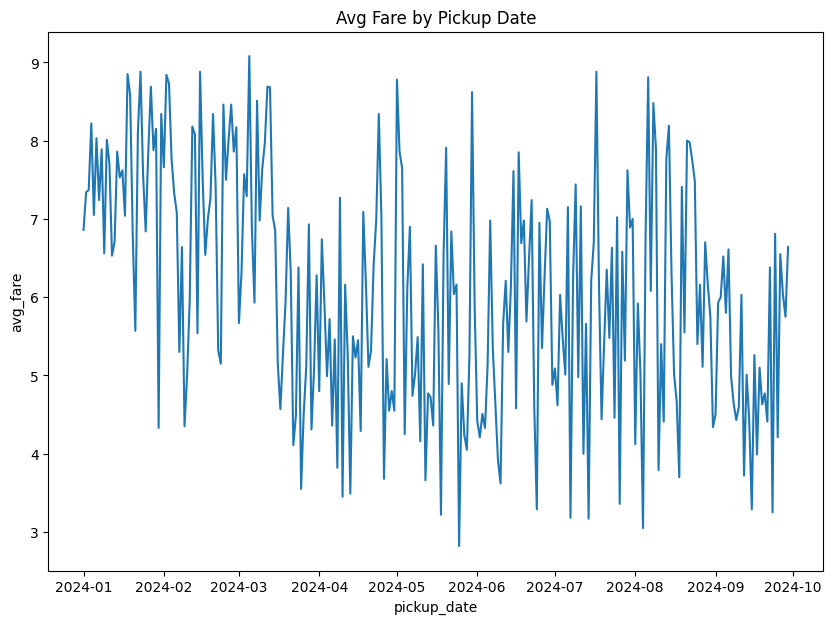

In [65]:
_st_time = datetime.now()
_=plt.figure(figsize=(10,7))
_=\
(
    ny_taxi_tb
    .filter("tpep_pickup_datetime between '2024-01-01' and '2024-9-30'")
    .aggregate(""" 
               tpep_pickup_datetime::date as pickup_date,
               -- duckdb allows pipe function such as func1().func2().func3() making it easire to read. 
               total_amount.sum().round()::int as tot_amt,
               sum(trip_distance).round()::int as tot_dist,
               (tot_amt/tot_dist).round(2) as avg_fare,
               count(*) as counts,
               """
            )
    .order('pickup_date')
    .df()
    .pipe(sns.lineplot,x='pickup_date',y='avg_fare')
)

_=plt.title("Avg Fare by Pickup Date")
_=get_elapsed_time(_st_time)

In [66]:
# Not the best way to measure max memory used by duckdb. 
# to highlight the memory usage between duckdb and pandas 
memory_used()

Memory used: 959 MBs


In [67]:
# convert output to Pandas or Arrow
# ~30M rows. ~4GB in Pandas
ny_taxi_df = ny_taxi_tb.df()

In [69]:
ny_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30021209 entries, 0 to 30021208
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee         

In [70]:
memory_used()

Memory used: 4,990 MBs


execution time: 18.83 seconds


18.83

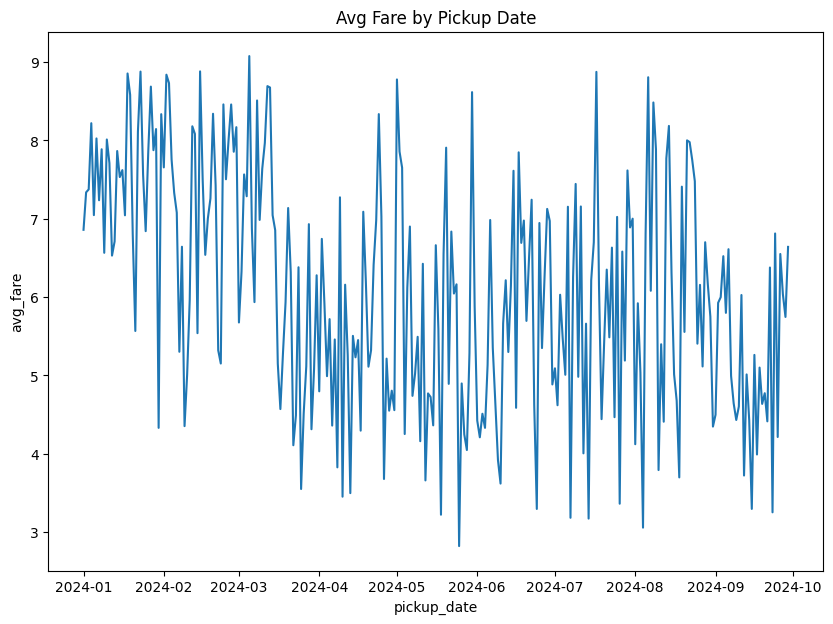

In [71]:
_st_time = datetime.now()
_=plt.figure(figsize=(10,7))
_=\
(
    ny_taxi_df
    .query("tpep_pickup_datetime >= '2024-01-01' and tpep_pickup_datetime <='2024-9-30'")
    .assign(pickup_date=lambda x:x['tpep_pickup_datetime'].dt.date)
    .groupby('pickup_date')
    .agg(
        tot_amt=('total_amount','sum'),
        tot_dist = ('trip_distance','sum'),
    )
    .assign(avg_fare=lambda df:df['tot_amt']/df['tot_dist'])
    .sort_index()
    .reset_index()
    .pipe(sns.lineplot,x='pickup_date',y='avg_fare')
)
_=plt.title("Avg Fare by Pickup Date")
get_elapsed_time(_st_time)

In [72]:
memory_used()

Memory used: 5,259 MBs


## Get the best of Python + SQL
* Better code organization using function and classes, for loops, etc.,
* wider python eco system for plotting,ML, etc., 


## Scaling outside the Warehouse using AWS Lambda

In [36]:
import boto3
import json
from functools import partial
import re
import s3fs
from time import sleep

In [37]:
%run utility.ipynb

In [38]:
lambda_client = boto3.client('lambda')
log_client = boto3.client('logs')

# create s3fs object
creds = boto3.Session().get_credentials().get_frozen_credentials()
_s3fs = s3fs.S3FileSystem(key=creds.access_key,secret=creds.secret_key,skip_instance_cache=True)

def get_s3_file_info(files: list):
    """ Function to get file info of s3 files"""
    _files = files if isinstance(files,list) else [files]
    return pd.DataFrame([_s3fs.info(file) for file in _files])

In [39]:
def get_aggregate_qry(input_path:str|list,output_path:str=None) :
    """ 
    Function
    """
    # if input path is str (signle file) convert to list
    input_path = input_path if isinstance(input_path,list) else [input_path]
    
    _agg_qry = f""" 
        select 
            tpep_pickup_datetime::date as pickup_date,
            sum(total_amount).round()::int as tot_amt,
            sum(trip_distance).round()::int as tot_dist,
            (tot_amt/tot_dist).round(2) as avg_fare,
            count(*) as counts
        from read_parquet({input_path})
        group by all
    """
    
    if output_path:
        _final_qry = f""" 
        COPY (
            {_agg_qry}
        ) 
        TO '{output_path}' (FORMAT PARQUET,OVERWRITE true)
        """
    else:
        _final_qry = _agg_qry
    
    return _final_qry
    

In [40]:
def generate_nytaxi_tasks(months:list,s3_output_base) -> dict:
    """ 
    Function to generate the tasks for each month
    """
    
    def get_output_path(month: str) -> str:
        return f"{s3_output_base.rstrip('/')}/agg_{month}.parquet"

    
    def get_qry(month: str) ->str:
        """ 
        get the aggregate query for the specified input/output paths
        """
        _input_file = get_nytaxi_data_path(month)
        _output_file = get_output_path(month)
        return get_aggregate_qry(
            input_path=_input_file,
            output_path=_output_file
        )
    
    def create_task(month: str) -> dict:
        """ 
        """    
        return {
            'qry':get_qry(month),
            'month':month,
            'output_path':get_output_path(month)
        }
    
    def create_tasks() -> dict:
        """ 
        """
        print(f"Generating {len(months)} tasks")
        return {month:create_task(month) for month in months}

    return create_tasks()

In [41]:
# months = get_months("2020-01","2024-09")
months = get_months('2024-01','2024-09')
output_base = "s3://adarshnamala/pydata_demo/ny_taxi/lambda/"
tasks = generate_nytaxi_tasks(months,s3_output_base=output_base)

Generating 9 tasks


In [42]:
tasks[months[0]]

{'qry': " \n        COPY (\n             \n        select \n            tpep_pickup_datetime::date as pickup_date,\n            sum(total_amount).round()::int as tot_amt,\n            sum(trip_distance).round()::int as tot_dist,\n            (tot_amt/tot_dist).round(2) as avg_fare,\n            count(*) as counts\n        from read_parquet(['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet'])\n        group by all\n    \n        ) \n        TO 's3://adarshnamala/pydata_demo/ny_taxi/lambda/agg_2024-01.parquet' (FORMAT PARQUET,OVERWRITE true)\n        ",
 'month': '2024-01',
 'output_path': 's3://adarshnamala/pydata_demo/ny_taxi/lambda/agg_2024-01.parquet'}

In [43]:
lambda_tasks = DuckdbLambda_Tasks(tasks=tasks,
                      lambda_client=lambda_client,
                      log_client=log_client)


In [84]:
lambda_tasks.event_invoke_tasks(qry_key='qry')

invoking #9 tasks


In [85]:
lambda_tasks.wait_until_tasks_complete(total_wait_time_secs=60,interval_check_time_sec=3)


Waiting until Tasks comeplete. 
Max wait time: 60 seconds. 
Check interval: 3 seconds
******************

iteration: 1. cummulative time: 0.0 seconds
Getting cloudwatch events
started tasks #9/9 tasks
Not started tasks #0/9 tasks
success tasks #9/9 tasks
Not success tasks #0/9 tasks
execution time: 10.81 seconds
******************


In [53]:
_files = [task['output_path'] for task in tasks.values()]
(
    get_s3_files_info(_files)
    ['LastModified'].agg(['min','max','size'])
)

min     2024-12-02 22:47:34+00:00
max     2024-12-02 22:47:36+00:00
size                            9
Name: LastModified, dtype: object

In [84]:
# if "~/.aws/credentials" file is setup, duckdb can use the credentials to setup AWS keys
_qry = f"""
INSTALL AWS; LOAD AWS;
CREATE SECRET secret2 (TYPE S3, PROVIDER CREDENTIAL_CHAIN);
"""
con.sql(_qry)

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ true    │
└─────────┘

In [96]:
_outfiles = [_['output_path'] for _ in tasks.values()]
_read_qry = ddb_read_parquet(_outfiles)
ddb_describe(_read_qry)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ pickup_date │ DATE        │ YES     │ NULL    │ NULL    │ NULL    │
│ tot_amt     │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ tot_dist    │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
│ avg_fare    │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ counts      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ filename    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [97]:
def get_monthly_summary(files):
    """ 
    Function to get the monthly min/max avg_fare
    """
    
    load_files = ddb_read_parquet(files)
    monthly_qry = f""" 
    with base AS (
        {load_files}
    )
    select 
    pickup_date.strftime('%Y-%m') as pickup_month,
   -- strftime(pickup_date,'%Y-%m') as pickup_month,
    max(avg_fare) as max_avg_fare,
    min(avg_fare) as min_avg_fare,
    sum(counts) as total_counts
    from base
    group by all
    order by pickup_month    
    """
    
    return monthly_qry

In [98]:
# get monthly min and max
st_time = datetime.now()
_qry = get_monthly_summary(_outfiles)

display(ddb_sql(_qry))  
_=get_elapsed_time(st_time)

┌──────────────┬──────────────┬──────────────┬──────────────┐
│ pickup_month │ max_avg_fare │ min_avg_fare │ total_counts │
│   varchar    │    double    │    double    │    int128    │
├──────────────┼──────────────┼──────────────┼──────────────┤
│ 2002-12      │          8.0 │          0.0 │           10 │
│ 2008-12      │         10.0 │         4.37 │            7 │
│ 2009-01      │         17.0 │          5.0 │           15 │
│ 2023-12      │         8.65 │         8.65 │           10 │
│ 2024-01      │         8.88 │         4.33 │      2964617 │
│ 2024-02      │         8.88 │         4.35 │      3007533 │
│ 2024-03      │         9.08 │         3.55 │      3582611 │
│ 2024-04      │         8.34 │         3.45 │      3514295 │
│ 2024-05      │         15.0 │         2.82 │      3723843 │
│ 2024-06      │         7.85 │         3.29 │      3539170 │
│ 2024-07      │         8.88 │         3.17 │      3076876 │
│ 2024-08      │         8.81 │         3.05 │      2979192 │
│ 2024-0

execution time: 1.18 seconds


**Run for 60 months**

In [99]:
# months = get_months("2020-01","2024-09")
months = get_months('2019-10','2024-09')
tasks = generate_nytaxi_tasks(months)

lambda_tasks = DuckdbLambda_Tasks(tasks=tasks,
                      lambda_client=lambda_client,
                      log_client=log_client)


Generating 60 tasks


In [91]:
lambda_tasks.event_invoke_tasks(qry_key='qry')

invoking #60 tasks


In [92]:
lambda_tasks.wait_until_tasks_complete(total_wait_time_secs=60,interval_check_time_sec=3)


Waiting until Tasks comeplete. 
Max wait time: 60 seconds. 
Check interval: 3 seconds
******************

iteration: 1. cummulative time: 0.0 seconds
Getting cloudwatch events
started tasks #29/60 tasks
Not started tasks #31/60 tasks
success tasks #26/60 tasks
Not success tasks #34/60 tasks

iteration: 2. cummulative time: 3.67 seconds
Getting cloudwatch events
started tasks #41/60 tasks
Not started tasks #19/60 tasks
success tasks #38/60 tasks
Not success tasks #22/60 tasks

iteration: 3. cummulative time: 7.32 seconds
Getting cloudwatch events
started tasks #58/60 tasks
Not started tasks #2/60 tasks
success tasks #57/60 tasks
Not success tasks #3/60 tasks

iteration: 4. cummulative time: 11.58 seconds
Getting cloudwatch events
started tasks #60/60 tasks
Not started tasks #0/60 tasks
success tasks #60/60 tasks
Not success tasks #0/60 tasks
execution time: 12.31 seconds
******************


In [100]:
# get monthly min and max
_outfiles = [_['output_path'] for _ in tasks.values()]
st_time = datetime.now()
_qry = get_monthly_summary(_outfiles)

display(ddb_sql(_qry))  
_=get_elapsed_time(st_time)

┌──────────────┬──────────────┬──────────────┬──────────────┐
│ pickup_month │ max_avg_fare │ min_avg_fare │ total_counts │
│   varchar    │    double    │    double    │    int128    │
├──────────────┼──────────────┼──────────────┼──────────────┤
│ 2001-01      │         7.25 │         3.63 │           11 │
│ 2001-08      │         3.57 │         3.57 │            1 │
│ 2002-10      │        10.66 │         5.25 │          439 │
│ 2002-12      │         11.0 │          0.0 │           25 │
│ 2003-01      │         8.33 │         3.14 │           29 │
│ 2003-03      │         NULL │         NULL │            1 │
│ 2004-04      │          6.0 │          6.0 │            1 │
│ 2008-12      │         24.0 │          3.2 │          245 │
│ 2009-01      │         17.0 │          2.0 │          430 │
│ 2011-01      │         8.67 │         8.67 │            2 │
│    ·         │           ·  │           ·  │            · │
│    ·         │           ·  │           ·  │            · │
│    ·  

execution time: 5.34 seconds


## Scaling using Coiled.io
* notebooks: https://docs.coiled.io/user_guide/notebooks.html
* serverless: https://docs.coiled.io/user_guide/functions.html
* price: https://www.coiled.io/pricing
* build vs buy: https://www.coiled.io/build-vs-buy

In [45]:
coiled.__version__

'1.66.1'

In [ ]:
# baseline settings for coiled Function params
ip_address= '170.85.72.183'
tags ={'Application ID':'RSH'}
coiled_function_params = dict(region='us-east-1',
                 arm=True,
                 idle_timeout='30 seconds',
                 spot_policy='spot',
                 memory='8 GB',
                 threads_per_worker=1,
                 name='pydata_demo',
                 allow_ingress_from = ip_address,
                 tags=tags)


def setup_ddb_con():
    """ 
    """
    con = duckdb.connect(":memory:")
    _aws_creds = """ 
    INSTALL AWS; LOAD AWS;
    CREATE SECRET secret2 (TYPE S3, PROVIDER CREDENTIAL_CHAIN);
    """
    con.sql(_aws_creds)
    return con
    

@coiled.function(**coiled_function_params)
def run_coiled_tasks(input: dict):
    """ 
    """
    
    _st = datetime.now()
    qry = input['qry']
    name = input['month']
    print(f"Running for task:{name}")
    # initiate duckdb connection
    con = setup_ddb_con()
    val =con.sql(qry)
    print(f"completed Task: {name} in {(datetime.now() - _st).seconds:.2f} seconds")
    
    return val
    

In [47]:
months = get_months('2024-01','2024-09')
output_base = "s3://adarshnamala/pydata_demo/ny_taxi/coiled/"
tasks = generate_nytaxi_tasks(months,s3_output_base=output_base)

Generating 9 tasks


In [ ]:
run_coiled_tasks.cluster.adapt(minimum=len(tasks),maximum=len(tasks))
result = run_coiled_tasks.map(list(tasks.values()))

[2024-12-03 08:34:06,680][INFO    ][coiled] Fetching latest package priorities...
[2024-12-03 08:34:06,680][INFO    ][coiled] Resolving your local pydata_global Python environment...
[2024-12-03 08:34:06,891][INFO    ][coiled.package_sync] Scanning 56 conda packages...
[2024-12-03 08:34:06,893][INFO    ][coiled.package_sync] Scanning 127 python packages...
[2024-12-03 08:34:07,087][INFO    ][coiled] Running pip check...
[2024-12-03 08:34:07,434][INFO    ][coiled] Validating environment...
[2024-12-03 08:34:09,173][INFO    ][coiled] Package - aiobotocore, Pip check had the following issues that need resolving: 
aiobotocore 2.15.2 has requirement botocore<1.35.37,>=1.35.16, but you have botocore 1.35.73.
[2024-12-03 08:34:09,174][INFO    ][coiled] Requesting package sync build...
[2024-12-03 08:34:10,002][INFO    ][coiled] Creating Cluster (name: pydata_demo, https://cloud.coiled.io/clusters/675289?account=adarshnamala ). This usually takes 1-2 minutes...
2024-12-03 08:34:55,515 - distri

## Coiled with Jupyter notbeooks

In [1]:
import pandas as pd
import numpy as np

In [1]:
# np.random.rand(10)